### Import scanpy

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import math
import matplotlib.ticker as mticker
from adjustText import adjust_text

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

In [3]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.12


# Load data 

In [4]:
adata = sc.read_h5ad('backups_JZ_2022/clean_kidney_304_15tr_25c_batch_corrected_50236x2000_220315_12h14.h5ad') 

In [5]:
# overwrite obs with the most recent version
filename = 'backups_JZ_2022/corrected_obs_info_50236x32_221012_12h04.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)
adata.obs = obs

In [6]:
adata.obs

,library,total_counts,pct_counts_mito,library2,sample,patient,pT stage,seq_date,beads,operation,...,n_counts,no_dblt_no_rbc,sp_cl_43,cell_type,broad_cell_type,color,cell_group,stage_color,patient_color,group_color
2,N14,449,0.668151,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,40,TAM 4,Immune,#9a5ce0,Myeloid cells,#8c1a1a,#e87f7f,#85619c
19,N14,449,4.23163,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,449,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#e87f7f,#85619c
363,N14,1229,10.6591,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,1229,True,22,Tumor cells 2,Tumor,#b06c6c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
433,N14,432,6.94444,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,432,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#e87f7f,#db2f2c
444,N14,502,4.98008,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,502,True,28,Tumor vasculature 4,Endothelial,#a35927,Endothelium,#8c1a1a,#e87f7f,#e07c57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4865536,Tumor0228,683,9.37042,T4_old,T4,P4,pT3a,old,old,Open,...,683,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865584,Tumor0228,1473,6.51731,T4_old,T4,P4,pT3a,old,old,Open,...,1473,True,30,TAM 2,Immune,#532b6b,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865642,Tumor0228,498,9.43775,T4_old,T4,P4,pT3a,old,old,Open,...,498,True,37,TAM 3,Immune,#943886,Myeloid cells,#8c1a1a,#70c3d4,#85619c
4865726,Tumor0228,421,19.2399,T4_old,T4,P4,pT3a,old,old,Open,...,421,True,27,Tumor cells 3,Tumor,#db2f2c,Tumor cells,#8c1a1a,#70c3d4,#db2f2c


### Scale (normalize) data

In [7]:
adata = adata.raw.to_adata()

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[ 449.]
 [ 449.]
 [1229.]
 [ 432.]
 [ 502.]]

[[10000.001]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [10000.   ]]


In [10]:
#select populations of interest
adata.obs['cell_type'].unique()

array(['TAM 4', 'TAM 3', 'Tumor cells 2', 'Tumor cells 3',
       'Tumor vasculature 4', 'TAM 1', 'CD8 T cells', 'TAM 2',
       'Resting/memory T cells', 'Cytotoxic T cells',
       'Tumor vasculature 2', 'Tumor vasculature 1',
       'Non-classical monocytes', 'Mesangial/vSMCs',
       'IGHG-high plasma cells', 'Mast cells', 'Tumor vasculature 3',
       'Plasma cells', 'Tumor AVR-like vasculature', 'Cycling', 'vSMCs',
       'NK cells', 'Classical monocytes', 'B cells', 'Myofibroblasts',
       'Regulatory T cells', 'Tumor cells 1', 'Proximal tubule', 'AVR',
       'Epithelial progenitor-like cells', 'tAL of LOH',
       'Glomerular endothelium', 'Principal cells', 'TAL of LOH', 'DVR',
       'Type A-ICs', 'OM Type A-ICs', 'Type B-IC', 'Podocytes', 'DCT/CNT'],
      dtype=object)

In [11]:
interest = ['Mesangial/vSMCs']

In [12]:
cmask_type = adata.obs['cell_type'].isin(interest)

In [13]:
sum(cmask_type)

1802

In [14]:


#label-free filter to remove very low abundance genes:
min_counts = 15
min_cells = 50

In [15]:
gmask = srz.filter_abund_genes(adata.X[cmask_type], min_counts, min_cells)

659 genes passing abundance filter


In [16]:
outdir = 'outputs_JZ_2022/'

In [17]:
import matplotlib as mpl
mpl.rc('font',family='Arial')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Volcano Mesangial/vSMC tumor vs healthy vasculature

In [18]:
adata.X[cmask_type].shape

(1802, 33538)

In [19]:
labcol = 'tissue'

In [20]:
adata.obs['tissue'].unique()

array(['Tumor', 'Healthy'], dtype=object)

In [21]:
#perform Mann-Whitney U and get FDR
#gmask is the same as before

cmask2 = adata.obs[labcol].isin(['Healthy']).values
cmask1 = adata.obs[labcol].isin(['Tumor']).values
print(cmask1.sum(), cmask2.sum())

# differential gene expression analysis
dge = rz.mwu(adata.X[cmask_type&cmask1,:][:,gmask].toarray(),
             adata.X[cmask_type&cmask2,:][:,gmask].toarray(),
             adata.var_names[gmask])

39091 11145


In [23]:
#get fold-change

# decide on pseudovalue to add to avoid division by zero, 1 seems to be the scanpy convention
pseudo = 1
dge['fc'] = (dge['mean1']+pseudo)/(dge['mean2']+pseudo)

In [24]:
dge['log2FC'] = np.log2(dge['fc'])

In [26]:
#Considering genes to be dirrefentially expressed if their fold-change is above 2 and 
# adjusted p-value is below 0.05

fc_ts = 2 
fdr_ts = 0.05 
dge['is_DGE'] = (dge['log2FC'].abs()>np.log2(fc_ts))&(dge['fdr']<fdr_ts)
dge

,U_statistic,p,fdr,mean1,mean2,fc,log2FC,is_DGE
HES4,116083.0,1.480865e-01,2.103211e-01,1.849702,1.825289,1.008641,0.012412,False
ISG15,137261.0,6.113385e-08,7.324946e-07,5.096470,1.876240,2.119597,1.083790,True
MRPL20,114758.0,2.679454e-01,3.435331e-01,1.696108,1.961234,0.910468,-0.135320,False
RPL22,125950.5,6.012786e-03,1.686139e-02,17.083298,15.446931,1.099494,0.136839,False
PARK7,120470.0,5.381912e-02,9.611598e-02,5.067348,4.590486,1.085299,0.118092,False
...,...,...,...,...,...,...,...,...
MT-ND4L,91710.0,9.706906e-07,9.138358e-06,1.648992,4.684264,0.466022,-1.101530,True
MT-ND4,50436.5,2.681713e-25,2.945415e-23,31.528854,74.942444,0.428336,-1.223186,True
MT-ND5,67838.5,2.150759e-14,7.086751e-13,8.866989,19.744818,0.475636,-1.072069,True
MT-ND6,104548.5,1.091181e-01,1.645510e-01,1.324750,3.359003,0.533322,-0.906922,False


In [27]:
dge['fdr'].min()

3.514236681045409e-27

In [28]:
#some of the adjusted p-values (fdr) are zero, that causes problems downstream
#here I replace such occurences with smallest observed fdr value

dge.loc[dge.fdr == 0, 'fdr'] =  sorted(set(dge['fdr']))[1]
        

In [29]:
sorted(set(dge['fdr']))[1]

5.402871896758858e-26

In [30]:
mask = dge['is_DGE'] == True

In [31]:
dge = dge[mask]
dge

,U_statistic,p,fdr,mean1,mean2,fc,log2FC,is_DGE
ISG15,137261.0,6.113385e-08,7.324946e-07,5.096470,1.876240,2.119597,1.083790,True
TXNIP,89551.0,7.544541e-06,5.649833e-05,2.776948,7.259875,0.457265,-1.128899,True
S100A6,63900.5,6.173714e-23,5.812111e-21,5.190986,20.425718,0.288951,-1.791102,True
S100A4,97664.5,6.495102e-04,2.718148e-03,2.740402,7.167725,0.457949,-1.126741,True
RGS5,164659.5,3.070049e-21,2.247958e-19,120.448174,58.339905,2.046653,1.033266,True
REN,119289.5,1.077542e-03,4.152634e-03,15.051831,3.417987,3.633290,1.861277,True
CYTOR,138263.5,5.464173e-09,8.573548e-08,3.566591,0.971917,2.315812,1.211518,True
TM4SF1,76453.0,4.424959e-14,1.388594e-12,2.513302,12.512539,0.260003,-1.943399,True
HOPX,90328.0,1.770278e-07,1.967628e-06,1.357646,4.594484,0.421423,-1.246658,True
GPX3,92985.0,1.978741e-04,9.659188e-04,3.147767,8.939943,0.417283,-1.260903,True


In [32]:
#save the results
dge.to_excel(outdir + 'mesangial_vsmc_tumor_vs_healthy.xlsx')

# Plot volcano plot

Here I am plotting a volcano plot where significant and differentially expressed genes are highlighted in blue or red (down- or up-regulated) with their number in the dataset, to avoid clutter plotting all the gene names. I am also saving a dictionary to decipher which number is which gene, and later on I can edit the image in Illustrator selecting the genes I wish to emphasize.

# gene up left 18
# genes up right 17


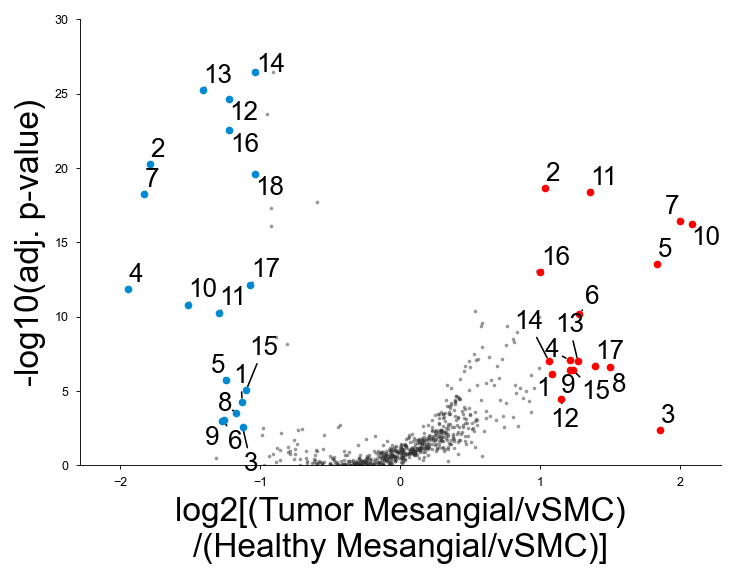

In [31]:
x = np.log2(dge['fc'])
y = -np.log10(dge['fdr'])

s = 3 #dotsize
c = '0.2'#dotcolor
alpha = 0.5 #dot transparency
lw = 0
# select thresholds for what to consider "hits"
fc_ts = 2 # 
fdr_ts = 0.05 # convention 

xlabel = 'log2[(Tumor Mesangial/vSMC)\n/(Healthy Mesangial/vSMC)]'
ylabel = '-log10(adj. p-value)'

# plot dots
a,fig,gs = rz.startfig(14,10)
a.scatter(x,y,c=c,s=s,lw=lw,alpha=alpha)

# center fold-change around zero:
xmax = abs(np.array(a.get_xlim())).max()
a.set_xlim(-xmax,xmax)


# plot thresholds:
(left,right) = a.get_xlim()
top = a.get_ylim()[1]
logfcts = np.log2(fc_ts)
logfdrts = -np.log10(fdr_ts)


# save hits as a list, color hits in red:
hitmask = dge['is_DGE']
hits = dge.index[hitmask]

# also split hit in those up left and up right
upleft = hits[dge.loc[hits,'fc']<1]
upright = hits[dge.loc[hits,'fc']>1]

numberTogeneUp = {} # Save genes up in text file made from dict to make your life easier in illustator/keynote
numberTogeneDo = {} # Save genes do in text file made from dict to make your life easier in illustator/keynote

textsUp = []
textsDo = []

iup = 1
ido = 1
for gene,m,n in zip(hits,x[hitmask],y[hitmask]):
    if m > 0: 
        a.scatter(m,n,lw=lw,s=s*4.5,c='r',alpha=1, zorder = 6)
        numberTogeneUp[gene] = iup
        textsUp.append(plt.text(m,n,iup,fontsize=12.5, zorder = 8))
        iup += 1
        
    elif m < 0: 
        a.scatter(m,n,lw=lw,s=s*4.5,c='#008ad4',alpha=1, zorder = 6)
        numberTogeneDo[gene] = ido
        textsDo.append(plt.text(m,n,ido,fontsize=12.5, zorder = 8))
        ido += 1

# Annotate significant DGE with numbers in plot (essential that adjust_text() is called last)
adjust_text(textsUp, 
            arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75),
            precision = 0.0000000001,
            force_text=(0.2, 0.45), 
            )
adjust_text(textsDo, 
            arrowprops=dict(arrowstyle='-', color='k', zorder = 4, lw = 0.75), 
            precision = 0.0000000001,
            force_text=(0.2, 0.45), 
            )

a.set_xlabel(xlabel, fontsize=16)
a.set_ylabel(ylabel, fontsize =16)

# set y-lim -log10(fdr cannot be less than 0)
a.set_ylim(0,30)

rz.showspines(a,left=True,bottom=True)



plt.savefig(outdir+'volcano_mesangial_tumor_vs_healthy.pdf', dpi=600, bbox_inches='tight')

# print the number of hits:
print('# gene up left',len(upleft))
print('# genes up right',len(upright))

In [33]:
upright

Index(['ISG15', 'RGS5', 'REN', 'CYTOR', 'CD36', 'TIMP1', 'FABP5', 'OLFML2A',
       'FXYD6', 'THY1', 'NDUFA4L2', 'COL4A1', 'COL4A2', 'TPPP3', 'CYGB',
       'CST3', 'COL18A1'],
      dtype='object')

In [34]:
numberTogeneUp

{'ISG15': 1,
 'RGS5': 2,
 'REN': 3,
 'CYTOR': 4,
 'CD36': 5,
 'TIMP1': 6,
 'FABP5': 7,
 'OLFML2A': 8,
 'FXYD6': 9,
 'THY1': 10,
 'NDUFA4L2': 11,
 'COL4A1': 12,
 'COL4A2': 13,
 'TPPP3': 14,
 'CYGB': 15,
 'CST3': 16,
 'COL18A1': 17}

In [35]:
numberTogeneDo

{'TXNIP': 1,
 'S100A6': 2,
 'S100A4': 3,
 'TM4SF1': 4,
 'HOPX': 5,
 'GPX3': 6,
 'NDUFA4': 7,
 'CRYAB': 8,
 'TSC22D1': 9,
 'APOE': 10,
 'TIMP3': 11,
 'MT-ND1': 12,
 'MT-ND2': 13,
 'MT-ATP6': 14,
 'MT-ND4L': 15,
 'MT-ND4': 16,
 'MT-ND5': 17,
 'MT-CYB': 18}

In [36]:
df_up = pd.DataFrame.from_dict([numberTogeneUp])
df_do = pd.DataFrame.from_dict([numberTogeneDo])

In [38]:
df_up.to_csv(outdir + 'mesang_up.csv')

In [39]:
df_do.to_csv(outdir + 'mesang_do.csv')